In [ ]:
!pip install farasapy
!git clone https://github.com/mohataher/arabic-stop-words.git

Cloning into 'arabic-stop-words'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (31/31), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
with open('/content/drive/MyDrive/ProjetTextMining/HESPRESS/arabic-stop-words-master/list.txt', 'r') as f:
  data = f.readlines()
arabic_stop_words = [x.strip() for x in data]
print(arabic_stop_words)

In [ ]:
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

segmenter = FarasaSegmenter(interactive = True)
stemmer = FarasaStemmer(interactive = True)

text = 'يُشار إلى أن اللغة العربية يتحدثها أكثر من'

In [ ]:
import re 
def preprocess_arabic_text(text):
  #print('Original text: ', text)
  segmented_text = segmenter.segment(text)
  #remove punctiation
  punctuation = re.sub('[^\w\s\']','',segmented_text)
  #remove numbers
  number = re.sub("[0-9><,]+"," ",punctuation)
  #print('Segmented text: ', segmented_text)
  stemmed_text = stemmer.stem(number)
  #print('Stemmed text: ', stemmed_text)
  tokens = stemmed_text.split()
  #print('Tokens: ',tokens)
  cleaned_text = [w for w in tokens if w not in arabic_stop_words]
  #print('Clean text: ', cleaned_text)
  return cleaned_text

In [ ]:
text = 'الناظور…فتح بحث قضائي لتحديد المتورطين في محاولة تهريب طنين و 380 كيلوغرام من مخدر الشيرا'
preprocess_arabic_text(text)

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ProjetTextMining/data/merge_from_ofoct (1).csv',
                 names=['text', 'date', 'link'])
df.head()

In [ ]:
preprocessed_text = df['text'].apply(preprocess_arabic_text).tolist()

In [ ]:
preprocessed_text[:1]

In [ ]:
import gensim
dictionary = gensim.corpora.Dictionary(preprocessed_text)
print(dictionary)

Dictionary(37625 unique tokens: ['MENA', 'آخر', 'آمن', 'أب', 'أبناك']...)


In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 100:
        break

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_text]
bow_corpus[2000]

In [ ]:
bow_doc_2000 = bow_corpus[2000]

for i in range(len(bow_doc_2000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2000[i][0], 
                                                     dictionary[bow_doc_2000[i][0]], 
                                                     bow_doc_2000[i][1]))

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)

In [ ]:
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
for index, score in sorted(lda_model[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

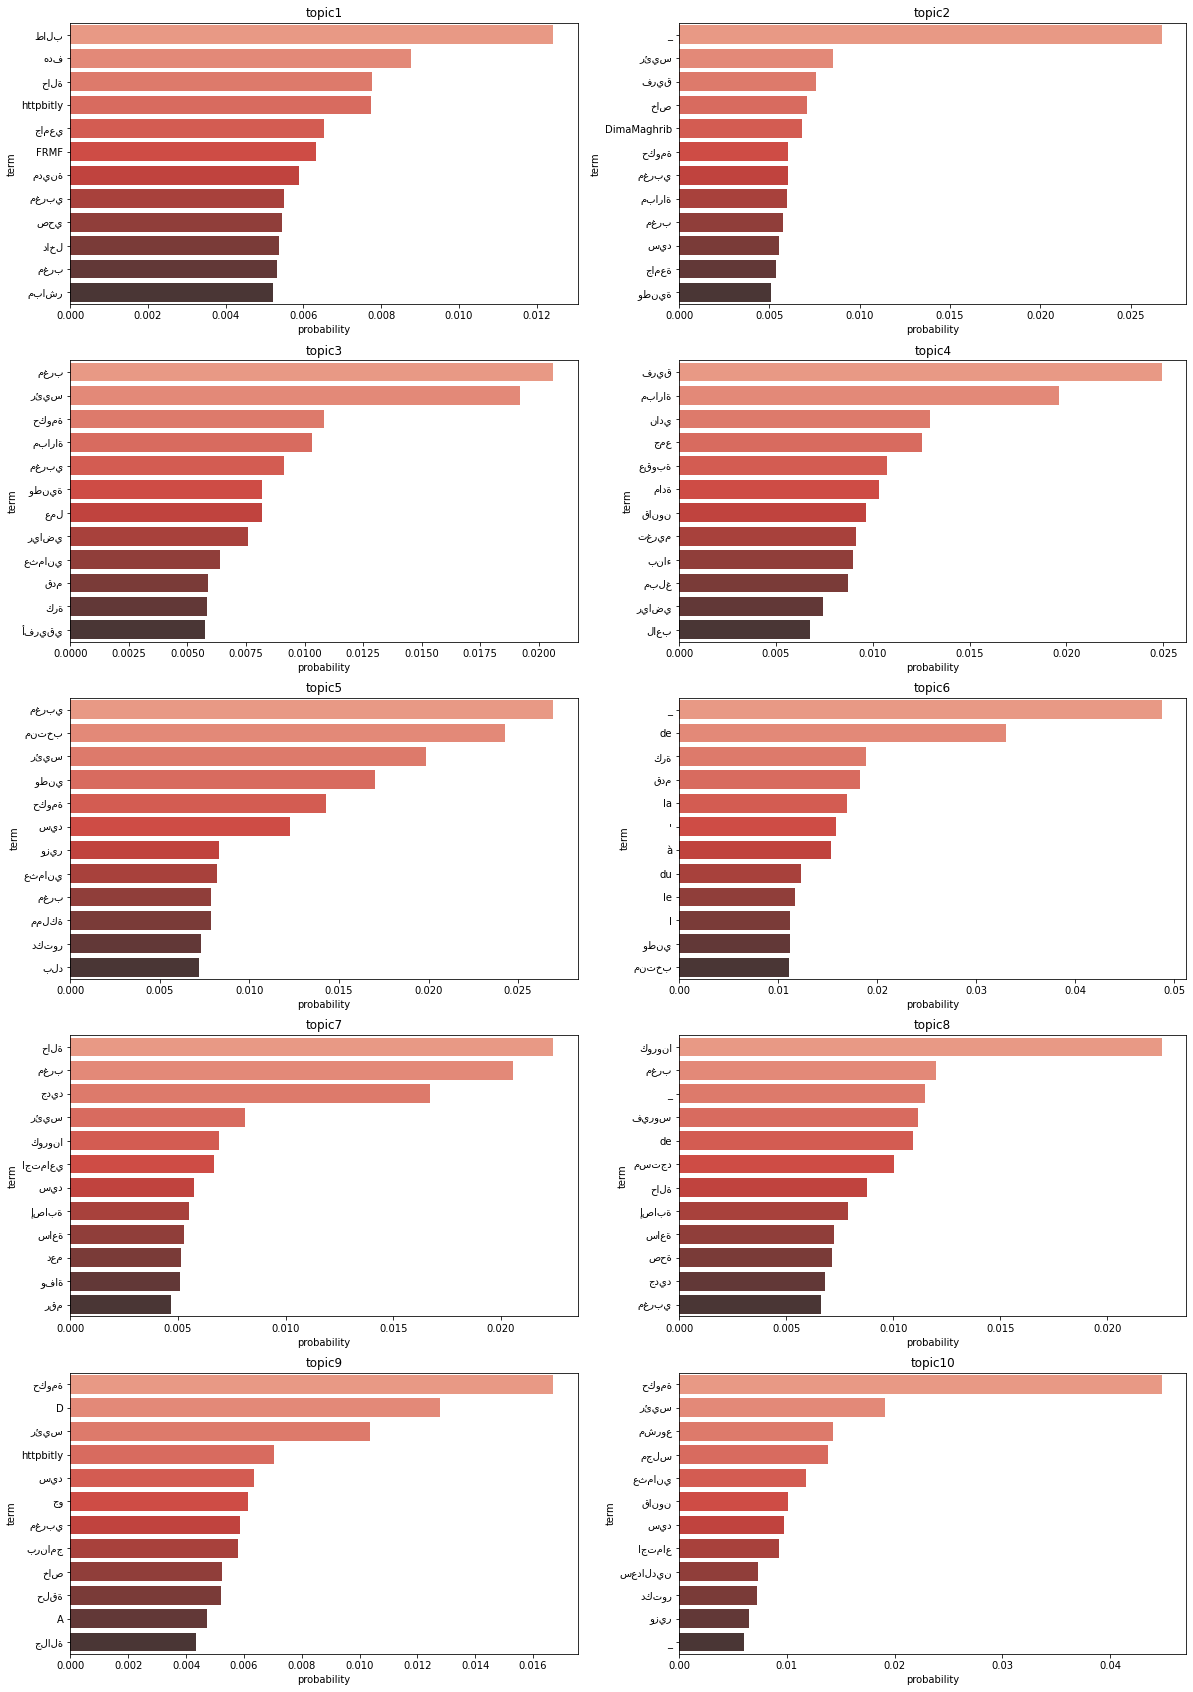

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

fig = plt.figure(figsize = (20,30))
    
for i in range(10):
    df = pd.DataFrame(lda_model.show_topic(i,12), columns=['term','prob']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('topic'+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df , label = 'Cities', palette='Reds_d')
    plt.xlabel('probability')
plt.show()